# Notebook for the Coursera Final Capstone Project

## This notebook contains all the script for the retireval and analysis of the relavant data

# Determining the best location to live

## Decision to be made on the study of secondary schools in the toronto neighborhood. The top 5 schools in top 3 neighborhoods will be displayed. FInally the best neighborhood will be suggested.

In [1]:
# importing the required libraries

from bs4 import BeautifulSoup 
import requests
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
print('All the packages imported')

All the packages imported


In [2]:
# This part of the code extracts the secondary school information fromm the below mentioned url
# in the below mentioned url the school information such as postal code is in another page
# this code scrpaes the wiki pages of each school in a loop and extracts the postal code
# the extracted postal code is appended to the list of schools and pass percentage data frame


source = requests.get('https://en.wikipedia.org/wiki/List_of_secondary_schools_in_the_Toronto_District_School_Board').text 
soup = BeautifulSoup(source,'lxml')
table = soup.find('table').tbody
rows = table.find_all('tr')
column_headers = [v.text.replace('\n','') for v in rows[0].find_all('th')]
column_headers.append('Postal code')
tds = pd.DataFrame(columns=column_headers)

urlsource = 'https://en.wikipedia.org/'

for i in range(1,len(rows)):
    
    row = [data for data in rows[i].find_all('td')]
    urllist = [link['href'] for link in (row[0].find_all('a',href=True))]
    url = urlsource + urllist[0]
    source1 = requests.get(url).text
    soup1 = BeautifulSoup(source1,'lxml')
    pc = soup1.find('div',{'class': 'postal-code'})
    row1 = [data.text.replace('\n','') for data in rows[i].find_all('td')]
    row1.append(pc.text[0:3])
    rowdf = pd.DataFrame([row1],columns=column_headers)       
    tds = tds.append(rowdf, ignore_index=True) 


tds.rename(columns={'Location':'Borough','Name[1]':'Name','Population (Dec. 2017)':'Population', 'EQAO Academic Math score (2016-2018)':'Math Score',
                    'OSSLT pass (2016-2018)':'OSSLT Pass Percentage'},inplace=True)
tds.drop(['Population','Special programs[2][3]','Picture'],axis=1,inplace=True)

tds

,Name,Borough,Math Score,ESL population,OSSLT Pass Percentage,Postal code
0,A. Y. Jackson Secondary School,North York,93%,84%,90%,M2H
1,Agincourt Collegiate Institute,Scarborough,90%,79%,92%,M1S
2,Albert Campbell Collegiate Institute,Scarborough,84%,86%,80%,M1V
3,Birchmount Park Collegiate Institute,Scarborough,67%,43%,70%,M1N
4,Bloor Collegiate Institute,Toronto,91%,65%,91%,M6H
...,...,...,...,...,...,...
64,William Lyon Mackenzie Collegiate Institute,North York,92%,67%,93%,M3H
65,Winston Churchill Collegiate Institute,Scarborough,73%,61%,64%,M1P
66,Woburn Collegiate Institute,Scarborough,78%,75%,79%,M1G
67,York Memorial Collegiate Institute,York,61%,62%,77%,M6M


In [3]:
# converting the pass percentage value to int

plist=[]
for i in tds['OSSLT Pass Percentage']:
    plist.append(int(i[0:2]))
    
tds['OSSLT Pass Percentage'] = plist
tds

,Name,Borough,Math Score,ESL population,OSSLT Pass Percentage,Postal code
0,A. Y. Jackson Secondary School,North York,93%,84%,90,M2H
1,Agincourt Collegiate Institute,Scarborough,90%,79%,92,M1S
2,Albert Campbell Collegiate Institute,Scarborough,84%,86%,80,M1V
3,Birchmount Park Collegiate Institute,Scarborough,67%,43%,70,M1N
4,Bloor Collegiate Institute,Toronto,91%,65%,91,M6H
...,...,...,...,...,...,...
64,William Lyon Mackenzie Collegiate Institute,North York,92%,67%,93,M3H
65,Winston Churchill Collegiate Institute,Scarborough,73%,61%,64,M1P
66,Woburn Collegiate Institute,Scarborough,78%,75%,79,M1G
67,York Memorial Collegiate Institute,York,61%,62%,77,M6M


In [4]:
# this part of the code extracts the Tornoto neighborhood data from the below mentioned url

source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text 
soup = BeautifulSoup(source,'lxml')
table = soup.find('table').tbody
rows = table.find_all('tr')
column_headers = [v.text.replace('\n','') for v in rows[0].find_all('th')] 
tdf = pd.DataFrame(columns=column_headers)

for i in range(1,len(rows)):
    row = [data.text.replace('\n','') for data in rows[i].find_all('td')]
    
    # assigning the empty neighborhoods to the names of the Boroughs
    
    if row[2]=='' or row[2]=='Not assigned':
        row[2]=row[1]                       
        
    # ignoring all the rows with Boroughs = Not Assigned and appending the remaining ones to tdf
    
    if row[1]!='Not assigned': 
        rowdf = pd.DataFrame([row],columns=column_headers)       
        tdf = tdf.append(rowdf, ignore_index=True) 

# dropping the rows with duplicate postal codes
tdf.drop_duplicates(subset = 'Postal code', inplace=True, ignore_index = True)
tdf

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,Business reply mail Processing CentrE
101,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...


In [5]:
# merging the two data frames to get the neighborhood information for each school

tds1 = tds.drop('Borough',axis=1)
tds1 = pd.merge(tdf,tds1,on='Postal code',how='inner')

tds1.drop(['Math Score','ESL population'],axis=1,inplace=True)
tds1

,Postal code,Borough,Neighborhood,Name,OSSLT Pass Percentage
0,M3A,North York,Parkwoods,George S. Henry Academy,68
1,M3A,North York,Parkwoods,Victoria Park Collegiate Institute,84
2,M6A,North York,Lawrence Manor / Lawrence Heights,John Polanyi Collegiate Institute,76
3,M9A,Etobicoke,Islington Avenue,Etobicoke Collegiate Institute,84
4,M9A,Etobicoke,Islington Avenue,Richview Collegiate Institute,94
...,...,...,...,...,...
64,M1W,Scarborough,Steeles West / L'Amoreaux West,Sir John A. Macdonald Collegiate Institute,87
65,M4W,Downtown Toronto,Rosedale,Rosedale Heights School of the Arts,95
66,M9W,Etobicoke,Northwest,Thistletown Collegiate Institute,72
67,M4Y,Downtown Toronto,Church and Wellesley,Jarvis Collegiate Institute,76


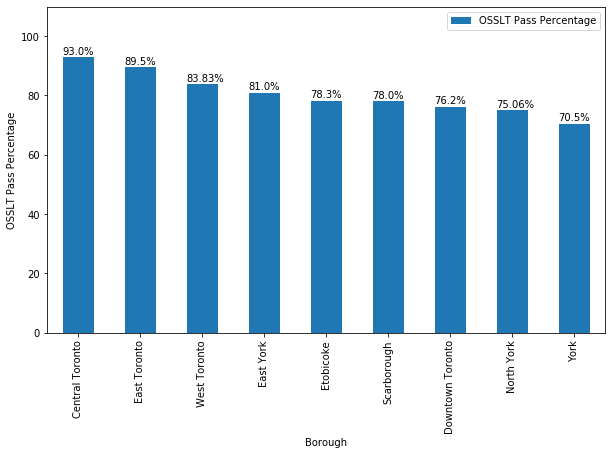

In [6]:
# sorting them based on OSSLT pass percentage to provide the top boroughs and neighborhoods to settle
# creating a bar graph to show the mean pass percentage of schools in the boroughs
import matplotlib.pyplot as plt

tds2 =tds1.groupby('Borough').mean().sort_values('OSSLT Pass Percentage',ascending=False)
ax = tds2.plot(kind='bar',figsize=(10,6))
plt.ylabel('OSSLT Pass Percentage')
plt.ylim(0,110)

for patch in ax.patches:
    width, height = patch.get_width(), patch.get_height()
    xc, yc = patch.get_xy()
    heightstr=str(round(height,2))+'%'
    ax.annotate(heightstr, (xc, yc + height + 1),fontsize=10)



In [7]:
# this part is going to display the schools from the top 3 boroughs 

tds3=tds1
boroughs = tds3['Borough']
size = len(boroughs)

for i in range(size):
    if ((boroughs[i] != 'West Toronto') & (boroughs[i] != 'East Toronto') & (boroughs[i] != 'Central Toronto')):
                tds3.drop(index=i,inplace=True)
    
tds3.reset_index(drop=True,inplace=True)
print('The top 5 chools from top 3 boroughs in descending order of pass percentages:')
tds3=tds3.sort_values('OSSLT Pass Percentage', ascending=False,ignore_index=True).head()
tds3

The top 5 chools from top 3 boroughs in descending order of pass percentages:


,Postal code,Borough,Neighborhood,Name,OSSLT Pass Percentage
0,M6P,West Toronto,High Park / The Junction South,Ursula Franklin Academy,99
1,M4P,Central Toronto,Davisville North,North Toronto Collegiate Institute,98
2,M4R,Central Toronto,North Toronto West,Lawrence Park Collegiate Institute,96
3,M4E,East Toronto,The Beaches,Malvern Collegiate Institute,94
4,M6P,West Toronto,High Park / The Junction South,Humberside Collegiate Institute,94


In [8]:
bestneighborhoods = tds3['Neighborhood'].value_counts().to_frame()
bestneighborhoods.rename(columns={'Neighborhood':'No. of Schools'},inplace=True)
bestneighborhoods.index.name='Neighborhood'
bestneighborhoods.reset_index(inplace=True)
bestneighborhoods.sort_values('No. of Schools', inplace=True)
bestneighborhood= bestneighborhoods['Neighborhood'][0]


print('The best neighborhood to live according to secondary school pass percentages is {}'.format(bestneighborhood))

The best neighborhood to live according to secondary school pass percentages is High Park / The Junction South


In [9]:
# displays the map for the location of top 5 schools



# Determining the best neighborhood for setting a coffee shop 

## Decision on the neighborhood to be made on the basis of that the coffee shop is not in top 5 venues for that particular neighborhood
## A table will be displayed to show the neighborhoods without coffee shop in top 3 venues

In [10]:
# the data frame tdf contains the borough and neighborhood information for Toronto
# now from the below mentioned csv file lat and lng data will be extracted

csv_path='C:\\Users\\karth\\Desktop\\Python\\Projects\\Capstone\\Toronto-Data-Project\\GC.csv'
df_latlng= pd.read_csv(csv_path)
df_latlng.rename(columns={'Postal Code':'Postal code'}, inplace=True)

In [11]:
# Concatenating the two data frames to make one
# tdf from the part 1 containing the boroughs and neighborhood data and df_latlng from part 2 containing the lat lng values

# first the indices in both of them are changed to the postal code as concatenation needs similar indices

df1 = df_latlng.set_index('Postal code')
df2 = tdf.set_index('Postal code')


# concatenation along y axis is done to add columns

tdf_new = pd.concat([df2,df1],axis=1)

# for the new data frame the index is reset and columns are renamed

tdf_new.reset_index(inplace=True)
tdf_new.rename(columns={'index':'Postal code'}, inplace=True)

tdf1 = tdf_new.drop('Postal code',axis=1)
tdf1

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...
98,Etobicoke,The Kingsway / Montgomery Road / Old Mill North,43.653654,-79.506944
99,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,East Toronto,Business reply mail Processing CentrE,43.662744,-79.321558
101,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...,43.636258,-79.498509


In [12]:
# tdf1 is the final data frame on which exploring will be done

# obtaining the coordinates of Tornoto usiong geopy

address = 'Toronto,Ontario'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [13]:
# creating the map of Toronto showing neighborhoods belonging to boroughs containing 'Toronto'

tmap = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(tdf1['Latitude'], tdf1['Longitude'], tdf1['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(tmap)  
    
tmap

In [14]:
# using foursquare api to explore the neighborhoods

CLIENT_ID = '25WDXR0CLBDJULQMQOO155NHAKNTZ0QFVZJPPTQPGURVZZQO' # your Foursquare ID
CLIENT_SECRET = 'MUHJSH3LKSVWCNNBAYFZWCTPLEL4LUAWLB5524OU30SVLEVS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 25WDXR0CLBDJULQMQOO155NHAKNTZ0QFVZJPPTQPGURVZZQO
CLIENT_SECRET:MUHJSH3LKSVWCNNBAYFZWCTPLEL4LUAWLB5524OU30SVLEVS


In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
    
    
#  getting the venues for all the neighborehoods in the borough containing 'Toronto'

tvenues = getNearbyVenues(names=tdf1['Neighborhood'],
                                   latitudes=tdf1['Latitude'],
                                   longitudes=tdf1['Longitude']
                                  )


tvenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [16]:
# analyzing the neighborhoods

# identifying the unique categories

tvenues.groupby('Neighborhood').count()
print('There are {} unique categories.'.format(len(tvenues['Venue Category'].unique())))

There are 273 unique categories.


In [17]:
# venue category is a categorical variable
# we can quantize it by using get_dummies method that converts it into an indicator
# in this step we can see how many venues of each category are present near each neighborhood 
# but one of the neighborhoods name is neighborhood, so to data frame the column name will be neighborhoods

t_hot = pd.get_dummies(tvenues[['Venue Category']], prefix="", prefix_sep="")

t_hot['Neighborhoods'] = tvenues['Neighborhood']

fixed_columns = [t_hot.columns[-1]] + list(t_hot.columns[:-1])
t_hot = t_hot[fixed_columns]
t_hot

,Neighborhoods,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,Mimico NW / The Queensway West / South of Bloo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2136,Mimico NW / The Queensway West / South of Bloo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2137,Mimico NW / The Queensway West / South of Bloo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2138,Mimico NW / The Queensway West / South of Bloo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# grouping the data frame by neighborhood and taking the means of indicator values of each venue
# higher the mean, higher is the number of venues of that category

tgroup = t_hot.groupby('Neighborhoods').mean().reset_index()

tgroup

,Neighborhoods,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0
1,Alderwood / Long Branch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0
2,Bathurst Manor / Wilson Heights / Downsview North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.052632,0.000,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0
4,Bedford Park / Lawrence Manor East,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,...,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Willowdale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.000000,0.025,0.0,0.0,0.0,0.0,0.0
91,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0
92,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.111111,0.000,0.0,0.0,0.0,0.0,0.0
93,York Mills / Silver Hills,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0


In [19]:
# now will display the top 'n' top venues for each of the neighborhoods
# tsorted dataframe will contain the dataframe

ntop = 5

indicators = ['st', 'nd', 'rd']

# assigning column headers

tsorted_columns = ['Neighborhoods']
                   
for ind in np.arange(ntop):
    try:
        tsorted_columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        tsorted_columns.append('{}th Most Common Venue'.format(ind+1))


#creating an empty dataframe

tsorted = pd.DataFrame(columns=tsorted_columns)

# sorting and creating the data frame with top 'n' venues

for hood in tgroup['Neighborhoods']:
    row = tgroup[tgroup['Neighborhoods']==hood].T.reset_index()
    row.columns =['Venue','Freq']
    row = row.iloc[1:]
    row['Freq'] = row['Freq'].astype(float).round(2)
    row =row.sort_values('Freq',ascending=False).reset_index(drop=True).head(ntop)
    
 
    
    rowdf = pd.DataFrame(row['Venue']).T.reset_index(drop=True) 
    rowdf.columns= tsorted_columns[1:len(tsorted_columns)+1]
    rowdf['Neighborhoods'] = hood

    fixed_columns = [rowdf.columns[-1]] + list(rowdf.columns[:-1])
    rowdf = rowdf[fixed_columns]
   
    tsorted = tsorted.append(rowdf, ignore_index=True) 
    
    
tsorted.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Breakfast Spot,Lounge,Latin American Restaurant,Skating Rink,Massage Studio
1,Alderwood / Long Branch,Pizza Place,Coffee Shop,Pharmacy,Sandwich Place,Gym
2,Bathurst Manor / Wilson Heights / Downsview North,Bank,Coffee Shop,Pizza Place,Pharmacy,Deli / Bodega
3,Bayview Village,Bank,Chinese Restaurant,Japanese Restaurant,Café,Accessories Store
4,Bedford Park / Lawrence Manor East,Sandwich Place,Restaurant,Coffee Shop,Italian Restaurant,Japanese Restaurant


In [20]:
x = tsorted.columns.tolist()

ts1 =  tsorted.set_index('1st Most Common Venue')
ts1.drop(['Coffee Shop'],inplace=True)
ts1.reset_index(inplace=True)
ts1 = ts1[x]

ts1 = ts1.set_index('2nd Most Common Venue')
ts1.drop(['Coffee Shop'],inplace=True)
ts1.reset_index(inplace=True)
ts1 = ts1[x]

ts1 = ts1.set_index('3rd Most Common Venue')
ts1.drop(['Coffee Shop'],inplace=True)
ts1.reset_index(inplace=True)
ts1 = ts1[x]


ts1 = ts1.set_index('4th Most Common Venue')
ts1.drop(['Coffee Shop'],inplace=True)
ts1.reset_index(inplace=True)
ts1 = ts1[x]


ts1 = ts1.set_index('5th Most Common Venue')
ts1.drop(['Coffee Shop'],inplace=True)
ts1.reset_index(inplace=True)
ts1 = ts1[x]

ts1.rename(columns={'Neighborhoods':'Neighborhood'},inplace=True)
ts1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Breakfast Spot,Lounge,Latin American Restaurant,Skating Rink,Massage Studio
1,Bayview Village,Bank,Chinese Restaurant,Japanese Restaurant,Café,Accessories Store
2,Birch Cliff / Cliffside West,General Entertainment,College Stadium,Skating Rink,Café,Accessories Store
3,Business reply mail Processing CentrE,Yoga Studio,Garden Center,Pizza Place,Comic Shop,Restaurant
4,CN Tower / King and Spadina / Railway Lands / ...,Airport Service,Airport Lounge,Plane,Boutique,Airport Food Court
5,Caledonia-Fairbanks,Park,Women's Store,Pool,Accessories Store,Mexican Restaurant
6,Cedarbrae,Bank,Gas Station,Bakery,Thai Restaurant,Hakka Restaurant
7,Cliffside / Cliffcrest / Scarborough Village West,Motel,American Restaurant,Movie Theater,Middle Eastern Restaurant,Moroccan Restaurant
8,Davisville North,Breakfast Spot,Department Store,Park,Sandwich Place,Food & Drink Shop
9,Del Ray / Mount Dennis / Keelsdale and Silvert...,Fast Food Restaurant,Bar,Sandwich Place,Accessories Store,Middle Eastern Restaurant


In [21]:
# this part appends back the Borough column to the above data frame 


tdf2 = tdf1.loc[:,'Borough':'Neighborhood']


ts2 = pd.merge(tdf2,ts1,on='Neighborhood',how='inner')


ts2.drop_duplicates(subset = 'Neighborhood', inplace=True, ignore_index = True)



In [22]:
# this part will display the top 5 venues for all the neighborhoods in the boroughs with top 3 schools namely, west,east and central toronto

ts3=ts2
boroughs = ts3['Borough']
size = len(boroughs)

for i in range(size):
    if ((boroughs[i] != 'West Toronto') & (boroughs[i] != 'East Toronto') & (boroughs[i] != 'Central Toronto')):
                ts3.drop(index=i,inplace=True)



In [23]:
# This part displays the table with boroughs and neighborhoods along with top 5 venues around that neighboirhood which 
# do not contain a coffee shop hence becoming the best places to set up coffee shop

ts3.reset_index(drop=True, inplace=True)
ts3

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,East Toronto,The Beaches,Health Food Store,Pub,Neighborhood,Trail,Monument / Landmark
1,West Toronto,Dufferin / Dovercourt Village,Pharmacy,Bakery,Brewery,Grocery Store,Middle Eastern Restaurant
2,West Toronto,Little Portugal / Trinity,Bar,Restaurant,Asian Restaurant,Café,Vietnamese Restaurant
3,East Toronto,India Bazaar / The Beaches West,Park,Sandwich Place,Fast Food Restaurant,Italian Restaurant,Pet Store
4,Central Toronto,Lawrence Park,Park,Swim School,Bus Line,Accessories Store,Mexican Restaurant
5,Central Toronto,Roselawn,Garden,Home Service,Middle Eastern Restaurant,Moroccan Restaurant,Monument / Landmark
6,Central Toronto,Davisville North,Breakfast Spot,Department Store,Park,Sandwich Place,Food & Drink Shop
7,Central Toronto,Forest Hill North & West,Bus Line,Sushi Restaurant,Jewelry Store,Trail,Accessories Store
8,West Toronto,High Park / The Junction South,Mexican Restaurant,Café,Thai Restaurant,Arts & Crafts Store,Fried Chicken Joint
9,West Toronto,Parkdale / Roncesvalles,Gift Shop,Movie Theater,Cuban Restaurant,Bar,Breakfast Spot


In [24]:
# diplays the map with locations of neighborhoods to setup coffee shop

ts4 = pd.merge(tdf1,ts3,on='Neighborhood',how='inner')
ts4 = ts4.loc[:,'Borough_x':'Longitude']
ts4.rename(columns={'Borough_x':'Borough'},inplace=True)

tmap = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(ts4['Latitude'], ts4['Longitude'], ts4['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(tmap)  
    
tmap

# K-Means clustering

In [26]:
# clustering the neighborhoods

# set number of clusters
kclusters = 5

tcluster = tgroup.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tcluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_.astype(int)
#tsorted.drop('Cluster Labels',axis=1,inplace=True)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 3, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 4, 1,
       0, 1, 1, 1, 1, 2, 0])

In [27]:
tsorted.insert(0,'Cluster Labels', kmeans.labels_)


In [28]:
tsorted.rename(columns={'Neighborhoods':'Neighborhood'},inplace=True)
tsorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,Agincourt,Breakfast Spot,Lounge,Latin American Restaurant,Skating Rink,Massage Studio
1,1,Alderwood / Long Branch,Pizza Place,Coffee Shop,Pharmacy,Sandwich Place,Gym
2,1,Bathurst Manor / Wilson Heights / Downsview North,Bank,Coffee Shop,Pizza Place,Pharmacy,Deli / Bodega
3,1,Bayview Village,Bank,Chinese Restaurant,Japanese Restaurant,Café,Accessories Store
4,1,Bedford Park / Lawrence Manor East,Sandwich Place,Restaurant,Coffee Shop,Italian Restaurant,Japanese Restaurant
...,...,...,...,...,...,...,...
90,1,Willowdale,Ramen Restaurant,Pizza Place,Coffee Shop,Restaurant,Café
91,1,Woburn,Coffee Shop,Korean Restaurant,Soccer Field,Monument / Landmark,Molecular Gastronomy Restaurant
92,1,Woodbine Heights,Cosmetics Shop,Video Store,Beer Store,Bus Stop,Dance Studio
93,2,York Mills / Silver Hills,Cafeteria,Accessories Store,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark


In [29]:
tmerged = pd.merge(tdf1,tsorted,on='Neighborhood',how='inner')
tmerged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,0,Park,Food & Drink Shop,Accessories Store,Mexican Restaurant,Molecular Gastronomy Restaurant
1,North York,Victoria Village,43.725882,-79.315572,1,Pizza Place,Hockey Arena,Portuguese Restaurant,Coffee Shop,Middle Eastern Restaurant
2,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,1,Coffee Shop,Bakery,Pub,Park,Breakfast Spot
3,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763,1,Accessories Store,Miscellaneous Shop,Clothing Store,Gift Shop,Furniture / Home Store
4,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,1,Coffee Shop,Diner,Sushi Restaurant,Yoga Studio,Café
...,...,...,...,...,...,...,...,...,...,...
95,Etobicoke,The Kingsway / Montgomery Road / Old Mill North,43.653654,-79.506944,0,Park,River,Accessories Store,Middle Eastern Restaurant,Monument / Landmark
96,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Yoga Studio
97,East Toronto,Business reply mail Processing CentrE,43.662744,-79.321558,1,Yoga Studio,Garden Center,Pizza Place,Comic Shop,Restaurant
98,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...,43.636258,-79.498509,1,Breakfast Spot,Baseball Field,Locksmith,Middle Eastern Restaurant,Monument / Landmark


In [30]:
# visulaization of the clusters

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tmerged['Latitude'], tmerged['Longitude'], tmerged['Neighborhood'], tmerged['Cluster Labels']):
    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [46]:
tmerged.loc[tmerged['Cluster Labels'] == 4, tmerged.columns[[1] + list(range(5, tmerged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,West Deane Park / Princess Gardens / Martin Gr...,Jewelry Store,Accessories Store,Miscellaneous Shop,Moroccan Restaurant,Monument / Landmark
